In [1]:
import numpy as np
import torch
import matplotlib.pylab as pl
import gudhi as gd
import gudhi.wasserstein as gdw
import persim
import ot
import ot.plot

In [2]:
import sys
sys.path.append('../code/')
sys.path.append('../code/ot_mmd/')
from generate_data import make_data
from persistence_diagram import curve_to_diagram
from sinkhorn_iterates import sinkhorn
from linear_solver import UOT_W
from utils import plot2D_plan,KL
from mmdot import solve_apgd
from mmdot_mirror_descent import solve_md
from utils_mmd import kernel,MMD

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


# 1st scenario

In [4]:
def f(x):
    return 5*(3*np.cos(x/2)-5*np.sin(-x)+np.sin(x/8)**2-np.cos(3*x))

In [5]:
x=np.linspace(1, 100, 500)
np.random.seed(0)
curve1 = f(x)+np.random.normal(0,1.6e0, size=x.shape)
curve2 = f(x)+np.random.normal(0,1.6e0, size=x.shape)

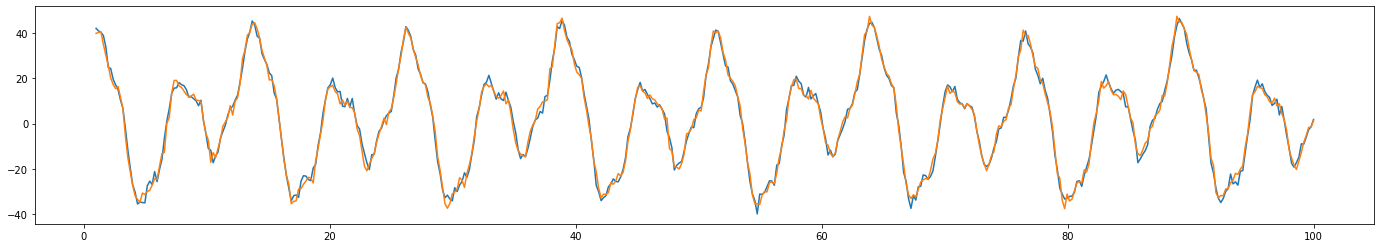

In [6]:
pl.figure(figsize=(24,4))
pl.plot(x,curve1)
pl.plot(x,curve2)

In [7]:
d1=curve_to_diagram(curve1)
d2=curve_to_diagram(curve2)

In [8]:
n=d1.shape[0]
m=d2.shape[0]
print(n,m)
a=np.ones(n+1)
b=np.ones(m+1)
a[-1],b[-1]=m,n

60 63


In [9]:
### Wasserstein ###
C=np.zeros((n+1,m+1))
C[:n,:m]=ot.dist(d1,d2)
C[-1,:m]=((d2[:, 1] - d2[:, 0])**2)/2
C[:n,-1]=((d1[:, 1] - d1[:, 0])**2)/2
Pw=ot.emd(a,b,C)

print(np.sum(Pw))
print(np.sum(Pw[:n,:m]))
W=np.sum(np.multiply(Pw,C))
print("sq Wasserstein",W)
print("Wasserstein",gdw.wasserstein_distance(d1, d2, matching=False, order=2, internal_p=2)**2)

123.0
42.0
sq Wasserstein 114.81638980762426
Wasserstein 114.8163898076242


In [10]:
### UOT KL ###
lam=4
PUOTKL=sinkhorn(torch.tensor(a),torch.tensor(b),torch.tensor(C),lam=lam,eps=5e-2,pen="kl",numiter=500).numpy()
print(np.sum(PUOTKL))
print(np.sum(PUOTKL[:n,:m]))
UOTKL=np.sum(np.multiply(PUOTKL,C))#+lam*KL(np.sum(PUOTKL,axis=1),a)+lam*KL(np.sum(PUOTKL,axis=0),b)
print("UOT KL",UOTKL)

112.22771266886022
31.75065427659134
UOT KL 56.562745733265615


In [11]:
# UOT W # with linear solver
Cx=np.zeros((n+1,n+1))
Cx[:n,:n]=ot.dist(d1,d1)
Cx[-1,:n]=((d1[:, 1] - d1[:, 0])**2)/2
Cx[:n,-1]=((d1[:, 1] - d1[:, 0])**2)/2
Cy=np.zeros((m+1,m+1))
Cy[:m,:m]=ot.dist(d2,d2)
Cy[-1,:m]=((d2[:, 1] - d2[:, 0])**2)/2
Cy[:m,-1]=((d2[:, 1] - d2[:, 0])**2)/2

lam=9e-1
PUOTW,Qx,Qy=UOT_W(a,b,C,lam=lam,Cx=Cx,Cy=Cy,innerplan=True)
UOTW=np.sum(np.multiply(PUOTW,C))#+lam*(np.sum(Qx*Cx)+np.sum(Qy*Cy))
print(UOTW)

56.863771084829075


In [12]:
### UOT MMD ###
Kx=torch.zeros((n+1,n+1))
Kx[:n,:n]=kernel(torch.tensor(d1),sigma=5)
Kx[-1,-1]=1
Ky=torch.zeros((m+1,m+1))
Ky[:m,:m]=kernel(torch.tensor(d2),sigma=5)
Ky[-1,-1]=1
G = {1: Kx, 2: Ky}

lam=7.4
PUOTMMD, _ = solve_apgd(torch.tensor(C).float(), G, 
                      v = {1: torch.tensor(a).float(), 2: torch.tensor(b).float()}, max_itr=1000, lda=lam, case="unb")
PUOTMMD=PUOTMMD.numpy()
UOTMMD=np.sum(np.multiply(PUOTMMD,C))#+lam*MMD(np.sum(PUOTMMD,axis=1),a,Kx.numpy())+lam*MMD(np.sum(PUOTMMD,axis=0),b,Ky.numpy())
print(UOTMMD)

57.179345080840974


In [13]:
### BOTTLENECK ###
B,matching=persim.bottleneck(d1, d2,matching=True)
print("Bottleneck",B)

Pb=np.zeros((d1.shape[0],d2.shape[0]))
Pbs=np.zeros((d1.shape[0],d1.shape[0]))
Pbt=np.zeros((d2.shape[0],d2.shape[0]))
for i in range(matching.shape[0]):
    if matching[i,0]!=-1 and matching[i,1] !=-1:
        Pb[int(matching[i,0]),int(matching[i,1])]=1
    if matching[i,0]==-1:
        Pbt[int(matching[i,1]),int(matching[i,1])]=1
    if matching[i,1]==-1:
        Pbs[int(matching[i,0]),int(matching[i,0])]=1

Bottleneck 3.20416259765625


In [14]:
# Distinction on the diagonal or not
theta=np.array([1/np.sqrt(2),1/np.sqrt(2)])
d1p=d1@theta
d1p=d1p[:,None]*theta[None,:]
d2p=d2@theta
d2p=d2p[:,None]*theta[None,:]

Pws=np.diag(Pw[:n,-1])
Pwt=np.diag(Pw[-1,:m])

PUOTKLs=np.round(np.diag(PUOTKL[:n,-1]),3)
PUOTKLt=np.round(np.diag(PUOTKL[-1,:m]),3)

PUOTWs=np.round(np.diag(PUOTW[:n,-1]),3)
PUOTWt=np.round(np.diag(PUOTW[-1,:m]),3)

PUOTMMDs=np.round(np.diag(PUOTMMD[:n,-1]),3)
PUOTMMDt=np.round(np.diag(PUOTMMD[-1,:m]),3)

/tmp/ipykernel_14001/2116870129.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


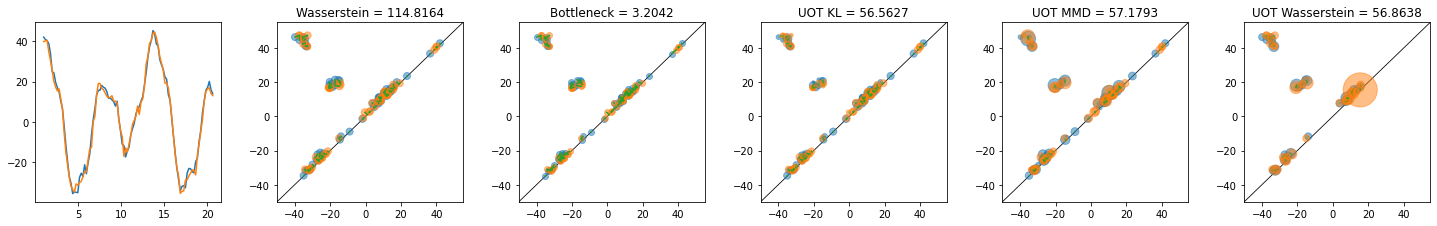

In [15]:
fig = pl.figure(figsize=(25,3.3))
grid = pl.GridSpec(1, 6, wspace=.3, hspace=0.3)
pl.subplot(grid[0, 0])
pl.plot(x[:100],curve1[:100])
pl.plot(x[:100],curve2[:100])

pl.subplot(grid[0, 1])
plot2D_plan(d1, d2, Pw[:n,:m], c="C2")
plot2D_plan(d1, d1p, Pws, c="C2")
plot2D_plan(d2, d2p, Pwt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(Pw[:n,:],axis=1)*50)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(Pw[:,:m],axis=0)*50)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("Wasserstein = %1.4f"%W)

pl.subplot(grid[0, 2])
plot2D_plan(d1, d2, Pb[:n,:m], c="C2")
plot2D_plan(d1, d1p, Pbs, c="C2")
plot2D_plan(d2, d2p, Pbt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("Bottleneck = %1.4f"%B)

pl.subplot(grid[0, 3])
plot2D_plan(d1, d2, PUOTKL[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTKLs, c="C2")
plot2D_plan(d2, d2p, PUOTKLt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(PUOTKL[:n,:],axis=1)*50)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(PUOTKL[:,:m],axis=0)*50)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("UOT KL = %1.4f"%UOTKL)

pl.subplot(grid[0, 4])
plot2D_plan(d1, d2, PUOTMMD[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTMMDs, c="C2")
plot2D_plan(d2, d2p, PUOTMMDt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(PUOTMMD[:n,:],axis=1)*50)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(PUOTMMD[:,:m],axis=0)*50)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("UOT MMD = %1.4f"%UOTMMD)

pl.subplot(grid[0, 5])
plot2D_plan(d1, d2, PUOTW[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTWs, c="C2")
plot2D_plan(d2, d2p, PUOTWt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(PUOTW[:n,:],axis=1)*50)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(PUOTW[:,:m],axis=0)*50)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("UOT Wasserstein = %1.4f"%UOTW)

pl.tight_layout()

In [16]:
# Compute ground truth
xtrue=np.linspace(1, 100,1000)
curve1true = f(x)
curve2true = f(x)
d1true=curve_to_diagram(curve1true)
d2true=curve_to_diagram(curve2true)
ntrue,mtrue=d1true.shape[0],d2true.shape[0]
atrue=np.ones(ntrue+1)
btrue=np.ones(mtrue+1)
atrue[-1],btrue[-1]=mtrue,ntrue
Ctrue=np.zeros((ntrue+1,mtrue+1))
Ctrue[:ntrue,:mtrue]=ot.dist(d1true,d2true)
Ctrue[-1,:mtrue]=((d2true[:, 1] - d2true[:, 0])**2)/2
Ctrue[:ntrue,-1]=((d1true[:, 1] - d1true[:, 0])**2)/2
Ptrue=ot.emd(atrue,btrue,Ctrue)
groundtruth=np.sum(Ptrue*Ctrue)

d1ptrue=d1true@theta
d1ptrue=d1ptrue[:,None]*theta[None,:]
d2ptrue=d2true@theta
d2ptrue=d2ptrue[:,None]*theta[None,:]

Ptrues=np.diag(Ptrue[:n,-1])
Ptruet=np.diag(Ptrue[-1,:m])

In [17]:
d1.shape,np.sum(Pw[:n,:],axis=1).shape

((60, 2), (60,))

In [18]:
"""PUOTS/=PUOTS[:n,:m].max()
PUOTSs/=PUOTS[:n,:m].max()
PUOTSt/=PUOTS[:n,:m].max()"""

'PUOTS/=PUOTS[:n,:m].max()\nPUOTSs/=PUOTS[:n,:m].max()\nPUOTSt/=PUOTS[:n,:m].max()'

/tmp/ipykernel_14001/1749973536.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


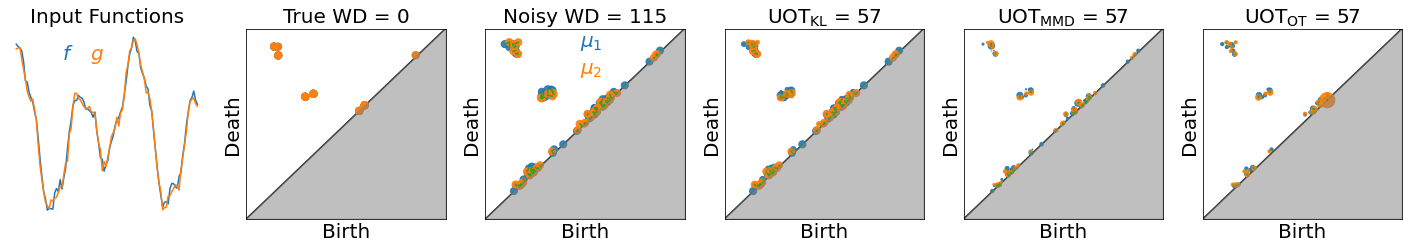

In [19]:
fig = pl.figure(figsize=(25,3.5))
grid = pl.GridSpec(1, 6, wspace=.2, hspace=.3)
pl.subplot(grid[0, 0])
pl.plot(x[:100],curve1[:100])
pl.plot(x[:100],curve2[:100])
pl.text(6,35,"$f$",color="C0",size=20)
pl.text(9,35,"$g$",color="C1",size=20)
pl.title("Input Functions",size=20)
pl.axis('off')

pl.subplot(grid[0, 1])
plot2D_plan(d1true, d2true, Ptrue[:n,:m], c="C2")
plot2D_plan(d1true, d1ptrue, Ptrues, c="C2")
plot2D_plan(d2true, d2ptrue, Ptruet, c="C2")
pl.scatter(d1true[:,0],d1true[:,1],c="C0",alpha=.9,s=np.sum(Ptrue[:ntrue,:],axis=1)*50)
pl.scatter(d2true[:,0],d2true[:,1],c="C1",alpha=.9,s=np.sum(Ptrue[:,:mtrue],axis=0)*50)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("True WD = %1.0f"%groundtruth,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 2])
plot2D_plan(d1, d2, Pw[:n,:m], c="C2")
plot2D_plan(d1, d1p, Pws, c="C2")
plot2D_plan(d2, d2p, Pwt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(Pw[:n,:],axis=1)*50)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(Pw[:,:m],axis=0)*50)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("Noisy WD = %1.0f"%W,size=20)
pl.text(0,45,"$\mu_1$",color="C0",size=20)
pl.text(0,30,"$\mu_2$",color="C1",size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 3])
plot2D_plan(d1, d2, PUOTKL[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTKLs, c="C2")
plot2D_plan(d2, d2p, PUOTKLt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTKL[:n,:],axis=1)*50)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTKL[:,:m],axis=0)*50)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("$\mathrm{UOT}_\\mathrm{KL}$ = %1.0f"%UOTKL,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 4])
plot2D_plan(d1, d2, PUOTMMD[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTMMDs, c="C2")
plot2D_plan(d2, d2p, PUOTMMDt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTMMD[:n,:],axis=1)*10)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTMMD[:,:m],axis=0)*10)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("$\mathrm{UOT}_\mathrm{MMD}$ = %1.0f"%UOTMMD,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 5])
plot2D_plan(d1, d2, PUOTW[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTWs, c="C2")
plot2D_plan(d2, d2p, PUOTWt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTW[:n,:],axis=1)*10)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTW[:,:m],axis=0)*10)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("$\mathrm{UOT}_\mathrm{OT}$ = %1.0f"%UOTW,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.tight_layout()
#pl.savefig("../Figures/PersistenceDiag1.pdf",bbox_inches='tight')

# Scenario 2

In [20]:
def f(x):
    return 35*np.sin(x)

def g(x):
    return 30*np.ones(x.shape[0])
    #return np.sin(x)-5

In [21]:
x=np.linspace(1, 100, 300)
np.random.seed(0)
curve1 = f(x)+np.random.normal(0,3e0, size=x.shape)
curve2 = g(x)+np.random.normal(0,3e0, size=x.shape)

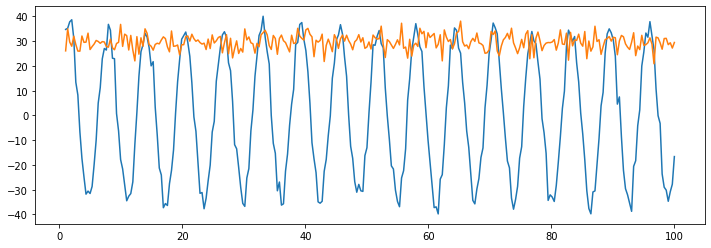

In [22]:
pl.figure(figsize=(12,4))
pl.plot(x,curve1)
pl.plot(x,curve2)

In [23]:
d1=curve_to_diagram(curve1)
d2=curve_to_diagram(curve2)

In [24]:
n=d1.shape[0]
m=d2.shape[0]
print(n,m)
a=np.ones(n+1)
b=np.ones(m+1)
a[-1],b[-1]=m,n

31 96


In [25]:
### Wasserstein ###
C=np.zeros((n+1,m+1))
C[:n,:m]=ot.dist(d1,d2)
C[-1,:m]=((d2[:, 1] - d2[:, 0])**2)/2
C[:n,-1]=((d1[:, 1] - d1[:, 0])**2)/2
Pw=ot.emd(a,b,C)

print(np.sum(Pw))
print(np.sum(Pw[:n,:m]))
W=np.sum(np.multiply(Pw,C))
print("sq Wasserstein",W)
print("Wasserstein",gdw.wasserstein_distance(d1, d2, matching=False, order=2, internal_p=2)**2)

127.0
5.0
sq Wasserstein 43925.89781434984
Wasserstein 43925.89781434984


In [26]:
### UOT KL ###
lam=4
PUOTKL=sinkhorn(torch.tensor(a),torch.tensor(b),torch.tensor(C),lam=lam,eps=5e0,pen="kl",numiter=500).numpy()
print(np.sum(PUOTKL))
print(np.sum(PUOTKL[:n,:m]))
UOTKL=np.sum(np.multiply(PUOTKL,C))+lam*KL(np.sum(PUOTKL,axis=1),a)+lam*KL(np.sum(PUOTKL,axis=0),b)
print("UOT KL",UOTKL)

81.19740493086931
19.188240387350394
UOT KL 623.4688010360753


In [27]:
# UOT W # with linear solver
Cx=np.zeros((n+1,n+1))
Cx[:n,:n]=ot.dist(d1,d1)
Cx[-1,:n]=((d1[:, 1] - d1[:, 0])**2)/2
Cx[:n,-1]=((d1[:, 1] - d1[:, 0])**2)/2
Cy=np.zeros((m+1,m+1))
Cy[:m,:m]=ot.dist(d2,d2)
Cy[-1,:m]=((d2[:, 1] - d2[:, 0])**2)/2
Cy[:m,-1]=((d2[:, 1] - d2[:, 0])**2)/2

lam=9e-1
PUOTW,Qx,Qy=UOT_W(a,b,C,lam=lam,Cx=Cx,Cy=Cy,innerplan=True)
UOTW=np.sum(np.multiply(PUOTW,C))+lam*(np.sum(Qx*Cx)+np.sum(Qy*Cy))

In [28]:
### UOT MMD ###
Kx=torch.zeros((n+1,n+1))
Kx[:n,:n]=kernel(torch.tensor(d1),sigma=5)
Kx[-1,-1]=1
Ky=torch.zeros((m+1,m+1))
Ky[:m,:m]=kernel(torch.tensor(d2),sigma=5)
Ky[-1,-1]=1
G = {1: Kx, 2: Ky}

lam=7.4
PUOTMMD, _ = solve_apgd(torch.tensor(C).float(), G, 
                      v = {1: torch.tensor(a).float(), 2: torch.tensor(b).float()}, max_itr=1000, lda=lam, case="unb")
PUOTMMD=PUOTMMD.numpy()
UOTMMD=np.sum(np.multiply(PUOTMMD,C))+lam*MMD(np.sum(PUOTMMD,axis=1),a,Kx.numpy())+lam*MMD(np.sum(PUOTMMD,axis=0),b,Ky.numpy())
print(UOTMMD)

3015.1638401029354


In [29]:
### BOTTLENECK ###
B,matching=persim.bottleneck(d1, d2,matching=True)
print("Bottleneck",B)

Pb=np.zeros((d1.shape[0],d2.shape[0]))
Pbs=np.zeros((d1.shape[0],d1.shape[0]))
Pbt=np.zeros((d2.shape[0],d2.shape[0]))
for i in range(matching.shape[0]):
    if matching[i,0]!=-1 and matching[i,1] !=-1:
        Pb[int(matching[i,0]),int(matching[i,1])]=1
    if matching[i,0]==-1:
        Pbt[int(matching[i,1]),int(matching[i,1])]=1
    if matching[i,1]==-1:
        Pbs[int(matching[i,0]),int(matching[i,0])]=1

Bottleneck 39.9160213142582


In [30]:
theta=np.array([1/np.sqrt(2),1/np.sqrt(2)])
d1p=d1@theta
d1p=d1p[:,None]*theta[None,:]
d2p=d2@theta
d2p=d2p[:,None]*theta[None,:]

Pws=np.diag(Pw[:n,-1])
Pwt=np.diag(Pw[-1,:m])

PUOTKLs=np.round(np.diag(PUOTKL[:n,-1]),3)
PUOTKLt=np.round(np.diag(PUOTKL[-1,:m]),3)

PUOTWs=np.round(np.diag(PUOTW[:n,-1]),3)
PUOTWt=np.round(np.diag(PUOTW[-1,:m]),3)

PUOTMMDs=np.round(np.diag(PUOTMMD[:n,-1]),3)
PUOTMMDt=np.round(np.diag(PUOTMMD[-1,:m]),3)

/tmp/ipykernel_14001/3644747969.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


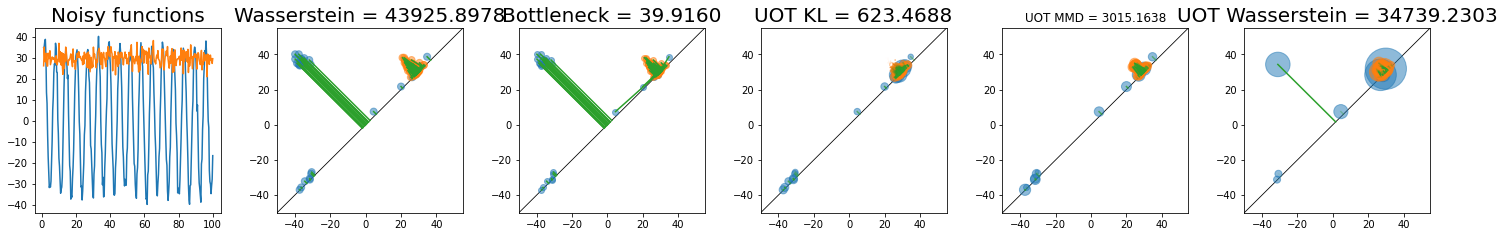

In [31]:
fig = pl.figure(figsize=(25,3.4))
grid = pl.GridSpec(1, 6, wspace=.3, hspace=0.3)
pl.subplot(grid[0, 0])
pl.plot(x,curve1)
pl.plot(x,curve2)
pl.title("Noisy functions",size=20)

pl.subplot(grid[0, 1])
plot2D_plan(d1, d2, Pw[:n,:m], c="C2")
plot2D_plan(d1, d1p, Pws, c="C2")
plot2D_plan(d2, d2p, Pwt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(Pw[:n,:],axis=1)*50)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(Pw[:,:m],axis=0)*50)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("Wasserstein = %1.4f"%W,size=20)

pl.subplot(grid[0, 2])
plot2D_plan(d1, d2, Pb[:n,:m], c="C2")
plot2D_plan(d1, d1p, Pbs, c="C2")
plot2D_plan(d2, d2p, Pbt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("Bottleneck = %1.4f"%B,size=20)

pl.subplot(grid[0, 3])
plot2D_plan(d1, d2, PUOTKL[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTKLs, c="C2")
plot2D_plan(d2, d2p, PUOTKLt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(PUOTKL[:n,:],axis=1)*50)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(PUOTKL[:,:m],axis=0)*50)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("UOT KL = %1.4f"%UOTKL,size=20)

pl.subplot(grid[0, 4])
plot2D_plan(d1, d2, PUOTMMD[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTMMDs, c="C2")
plot2D_plan(d2, d2p, PUOTMMDt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(PUOTMMD[:n,:],axis=1)*50)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(PUOTMMD[:,:m],axis=0)*50)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("UOT MMD = %1.4f"%UOTMMD)

pl.subplot(grid[0, 5])
plot2D_plan(d1, d2, PUOTW[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTWs, c="C2")
plot2D_plan(d2, d2p, PUOTWt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(PUOTW[:n,:],axis=1)*50)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(PUOTW[:,:m],axis=0)*50)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("UOT Wasserstein = %1.4f"%UOTW,size=20)

pl.tight_layout()

In [32]:
# Compute ground truth
xtrue=np.linspace(1, 100, 3000)
curve1true = f(xtrue)
curve2true = g(xtrue)
d1true=curve_to_diagram(curve1true)
d2true=curve_to_diagram(curve2true)
ntrue,mtrue=d1true.shape[0],d2true.shape[0]
atrue=np.ones(ntrue+1)
btrue=np.ones(mtrue+1)
atrue[-1],btrue[-1]=mtrue,ntrue
Ctrue=np.zeros((ntrue+1,mtrue+1))
Ctrue[:ntrue,:mtrue]=ot.dist(d1true,d2true)
Ctrue[-1,:mtrue]=((d2true[:, 1] - d2true[:, 0])**2)/2
Ctrue[:ntrue,-1]=((d1true[:, 1] - d1true[:, 0])**2)/2
Ptrue=ot.emd(atrue,btrue,Ctrue)
groundtruth=np.sum(Ptrue*Ctrue)

d1ptrue=d1true@theta
d1ptrue=d1ptrue[:,None]*theta[None,:]
d2ptrue=d2true@theta
d2ptrue=d2ptrue[:,None]*theta[None,:]

Ptrues=np.diag(Ptrue[:n,-1])
Ptruet=np.diag(Ptrue[-1,:m])

In [33]:
d1.shape,np.sum(Pw[:n,:],axis=1).shape

((31, 2), (31,))

/tmp/ipykernel_14001/2401440583.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


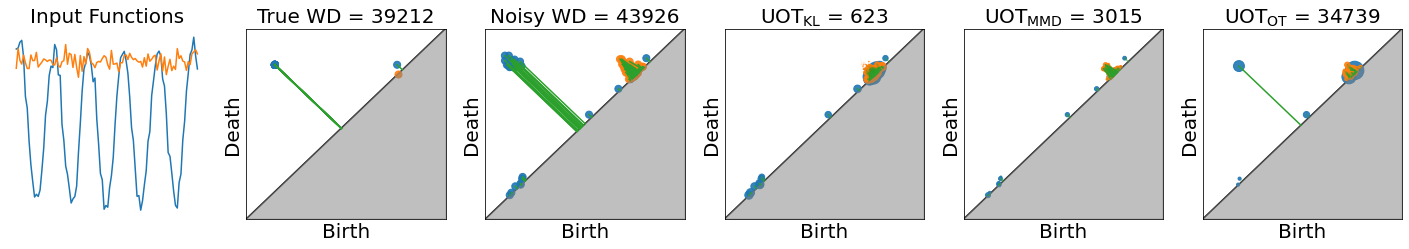

In [34]:
fig = pl.figure(figsize=(25,3.5))
grid = pl.GridSpec(1, 6, wspace=.2, hspace=.3)
pl.subplot(grid[0, 0])
pl.plot(x[:100],curve1[:100])
pl.plot(x[:100],curve2[:100])
pl.axis('off')
pl.title("Input Functions",size=20)

pl.subplot(grid[0, 1])
plot2D_plan(d1true, d2true, Ptrue[:n,:m], c="C2")
plot2D_plan(d1true, d1ptrue, Ptrues, c="C2")
plot2D_plan(d2true, d2ptrue, Ptruet, c="C2")
pl.scatter(d1true[:,0],d1true[:,1],c="C0",alpha=.9,s=np.sum(Ptrue[:ntrue,:],axis=1)*50)
pl.scatter(d2true[:,0],d2true[:,1],c="C1",alpha=.9,s=np.sum(Ptrue[:,:mtrue],axis=0)*50)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("True WD = %1.0f"%groundtruth,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 2])
plot2D_plan(d1, d2, Pw[:n,:m], c="C2")
plot2D_plan(d1, d1p, Pws, c="C2")
plot2D_plan(d2, d2p, Pwt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(Pw[:n,:],axis=1)*50)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(Pw[:,:m],axis=0)*50)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("Noisy WD = %1.0f"%W,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 3])
plot2D_plan(d1, d2, PUOTKL[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTKLs, c="C2")
plot2D_plan(d2, d2p, PUOTKLt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTKL[:n,:],axis=1)*50)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTKL[:,:m],axis=0)*50)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("$\mathrm{UOT}_\mathrm{KL}$ = %1.0f"%UOTKL,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 4])
plot2D_plan(d1, d2, PUOTMMD[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTMMDs, c="C2")
plot2D_plan(d2, d2p, PUOTMMDt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTMMD[:n,:],axis=1)*10)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTMMD[:,:m],axis=0)*10)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("$\mathrm{UOT}_\mathrm{MMD}$ = %1.0f"%UOTMMD,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 5])
plot2D_plan(d1, d2, PUOTW[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTWs, c="C2")
plot2D_plan(d2, d2p, PUOTWt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTW[:n,:],axis=1)*10)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTW[:,:m],axis=0)*10)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("$\mathrm{UOT}_\mathrm{OT}$ = %1.0f"%UOTW,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)


pl.tight_layout()
#pl.savefig("../Figures/PersistenceDiag2.pdf",bbox_inches='tight')

### Evolution of cost with lambda

In [81]:
# UOT W
lam1=np.linspace(0, 5e1, num=50)
Cost_OT=[]
for l in lam1:
    PUOTW,Qx,Qy=UOT_W(a,b,C,lam=l,Cx=Cx,Cy=Cy,innerplan=True)
    Cost_OT+=[np.sum(np.multiply(PUOTW,C))+l*(np.sum(Qx*Cx)+np.sum(Qy*Cy))]    

In [86]:
# UOT KL
lam2=np.linspace(0, 1e5, num=50)
Cost_KL=[]
for l in lam2:
    PUOTKL=sinkhorn(torch.tensor(a),torch.tensor(b),torch.tensor(C),lam=l,eps=5,pen="kl",numiter=500).numpy()
    Cost_KL+=[np.sum(np.multiply(PUOTKL,C))+l*KL(np.sum(PUOTKL,axis=1),a)+l*KL(np.sum(PUOTKL,axis=0),b)]

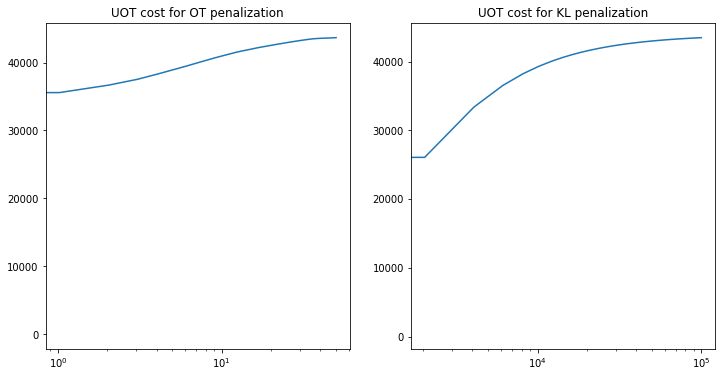

In [87]:
pl.figure(figsize=(12,6))
pl.subplot(1,2,1)
pl.plot(lam1,Cost_OT)
pl.title("UOT cost for OT penalization")
#pl.xscale('log')
pl.subplot(1,2,2)
pl.plot(lam2,Cost_KL)
pl.title("UOT cost for KL penalization")
#pl.xscale('log')

# Concatenate functions

In [11]:
def f1(x):
    return 5*(3*np.cos(x/2)-5*np.sin(-x)+np.sin(x/8)**2-np.cos(3*x))

def f2(x):
    return 35*np.sin(x)

def g(x):
    return 30*np.ones(x.shape[0])
    #return np.sin(x)-5

In [12]:
x1=np.linspace(1, 51, 200)
np.random.seed(0)
curve11 = f1(x1)+np.random.normal(0,1.6e0, size=x1.shape)
curve12 = f1(x1)+np.random.normal(0,1.6e0, size=x1.shape)

x2=np.linspace(51, 100, 200)
np.random.seed(0)
curve21 = f2(x2)+np.random.normal(0,1.6e0, size=x2.shape)
curve22 = g(x2)+np.random.normal(0,1.6e0, size=x2.shape)

In [13]:
curve1=np.concatenate((curve11,curve21))
curve2=np.concatenate((curve12,curve22))
x=np.concatenate((x1,x2))

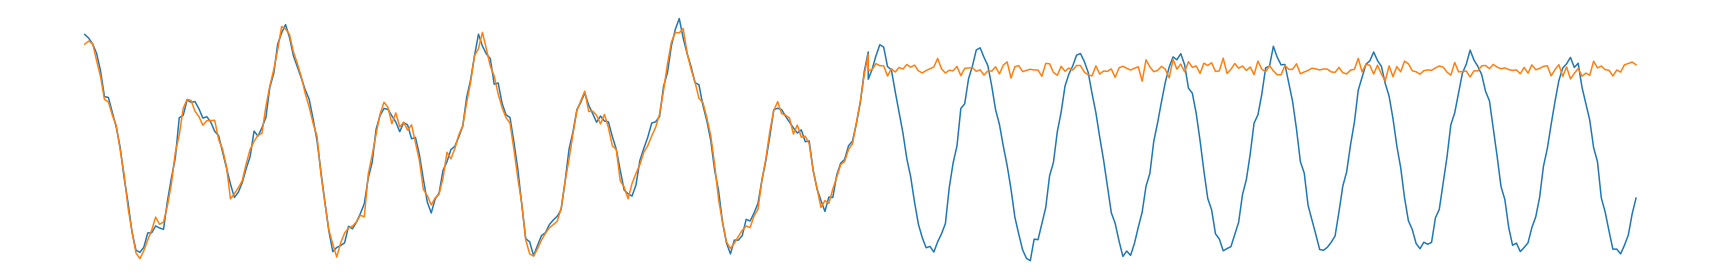

In [14]:
pl.figure(figsize=(24,4))
pl.plot(x,curve1)
pl.plot(x,curve2)
pl.axis('off')
pl.tight_layout()
pl.savefig("../Figures/NoisyFunConcat.pdf",bbox_inches='tight')

In [148]:
"""def f(x):
    return -.2*np.ones(x.shape)

def g(x):
    return -np.exp(-((x/15)**2))-np.exp(-(((x+50)/15)**2))-np.exp(-(((x-50)/15)**2))"""

"""def g(x):
    return 4*(np.sin(1/x)-2*np.cos(x-2)**2+2*np.sin(x/8)**2-np.cos(x))+10*np.sin(x)-5

def h(x):
    h=f(x)
    for i in range(1,100,8):
        h=h-10*np.exp(-(x-i)**2)
    return h"""

'def g(x):\n    return 4*(np.sin(1/x)-2*np.cos(x-2)**2+2*np.sin(x/8)**2-np.cos(x))+10*np.sin(x)-5\n\ndef h(x):\n    h=f(x)\n    for i in range(1,100,8):\n        h=h-10*np.exp(-(x-i)**2)\n    return h'